# Homework 1: Numpy, Scipy, Pandas

### Due Tues Feb 1, 2022 @ 8pm


## #0: Get set up with your environment to work on and submit homework

a. Create a new homework repository at github

<img src="data/screenshot_1.png">

Name your repo something sensible (e.g., python-ay250-homeworks). Given your Berkeley affiliation you should be able to get private repos if you'd like.

<img src="data/screenshot_2.png">


b. Clone this repo locally and make a directory for this week's homework:

```bash
cd /class/directories ## this will be different on your machine...whereever you want to keep your work.

# change <username> to your github username:
git clone https://github.com/<username>/python-ay250-homework.git
cd python-ay250-homework
mkdir hw_1
echo "hw_1 README" >> hw_1/README.md
git add hw_1/README.md
git commit hw_1/README.md -m "added hw_1 directory"
git push
```

c. Copy this notebook into your `hw_1` folder from a local version of the python-seminar repo

```bash
cd /class/directories
git clone https://github.com/profjsb/python-seminar.git 
cd python-seminar
git pull
cp -r Homeworks/hw_1/* /class/directories/python-ay250-homework/hw_1/
```

d. Get working! Be sure to check in your work as often as you'd like

```bash
cd /class/directories/python-ay250-homework
git add hw_1/<whatever>
git commit <whatever> -m "this is a check in"
git push
```

e. To submit your work, go to this form to register your homework Repo URL (https://forms.gle/z9XZqCD5Ra9ikTGQ8). If you've made your repo private, you'll need to add us as collaborators to the repo.  Our Github handles are `@profjsb` and `@elliesch`.

## #1:  Super-resolution imaging 

Obtaining several snapshots of the same scene, from microscopes to telescopes, is useful for the postprocessing increase of signal to noise: by summing up imaging data we can effectively beat down the noise. Interestingly, if we image the same scene from different vistas we can also improve the clarity of the combined image. Being able to discern features in a scene from this combination effort is sometimes called super-resolution imaging.

Here, we'll combine about 4 seconds of a shaky video to reveal the statement on a license plate that is not discernable in any one frame.

<img src="Data/im2-1.png">

A tarball of the data is at: https://zenodo.org/record/5889322/files/homework1_data.tgz?download=1 (Zenodo page for the course: https://zenodo.org/record/5889322). This file is also in the read-only directory on `astro.datahub.berkeley.edu`.

```bash
tar -xvzf homework1_data.tgz  # do NOT check this files into git...
```

**Problem 1** Read in each image into a `numpy` array. Resize each frame to be 3 times larger in each axis (ie. 9 times larger images). Using `scipy.signal.fftconvolve` find the offsets of each frame with respect to the first frame. Report those offsets to 2 decimal places. 

   - Hint0: you can use `PIL` to read the images or `matplotlib.pyplot.imread`
```python
from PIL import Image
array = Image.open(fname).convert('L')
```
   - Hint1: you'll need to figure out how to resize a numpy array. Check out PIL.Image.resize...
   - Hint2: you'll want to reverse the second image when doing the convolution: `scipy.signal.fftconvolve(im1, im2[::-1, ::-1])`
   - Hint3: you'll need to figure out how to identify the peak of the fft convolution to find the offsets between images

In [1]:
from PIL import Image
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# I/O and resizing

data = [] 
files = glob.glob('data/im2-*.png')
for f in files:
    tmp = Image.open(f).convert('L')
    w = tmp.size[0]
    tmp = np.array(tmp.resize(size=(w*3,w*3)))
    w *= 3
    tmp[tmp==255] = 0
    data.append(tmp)

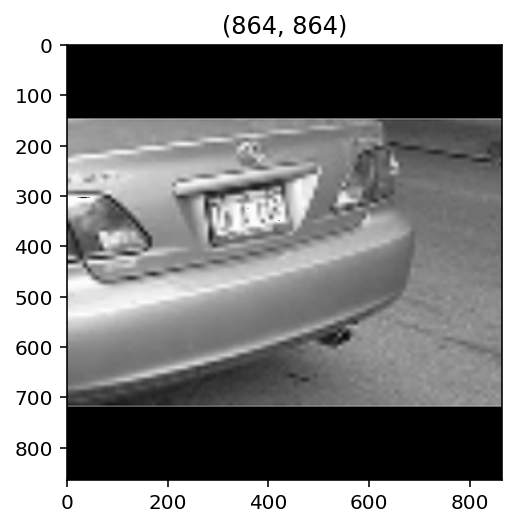

In [3]:
plt.imshow(data[0], cmap='gray')
plt.title(data[0].shape)
plt.show()

In [4]:
# where is the zero boundary?
zeros = np.arange(w)
zeros = zeros[np.sum(data[0], axis=1)==0]

for i in range(len(zeros)-1):
    if zeros[i+1] - zeros[i] > 1:
        print(zeros[i], zeros[i+1])

145 718


In [5]:
# convolution to find offset
def find_shift(im1, im2):
    im1 = im1[146:718]
    im2 = im2[146:718]

    autocorr = signal.fftconvolve(im1-np.mean(im1), (im2-np.mean(im2))[::-1, ::-1], mode='same')

#     auto1 = signal.fftconvolve(im1, im1[::-1, ::-1], mode='same') # another way?
#     auto2 = signal.fftconvolve(im1, im2[::-1, ::-1], mode='same')
#     autocorr = auto2 - auto1

    plt.imshow(autocorr)
    pos_max = np.where(autocorr==np.max(autocorr))
    max_x, max_y = 145 + pos_max[0][0], pos_max[1][0]

    return max_x, max_y

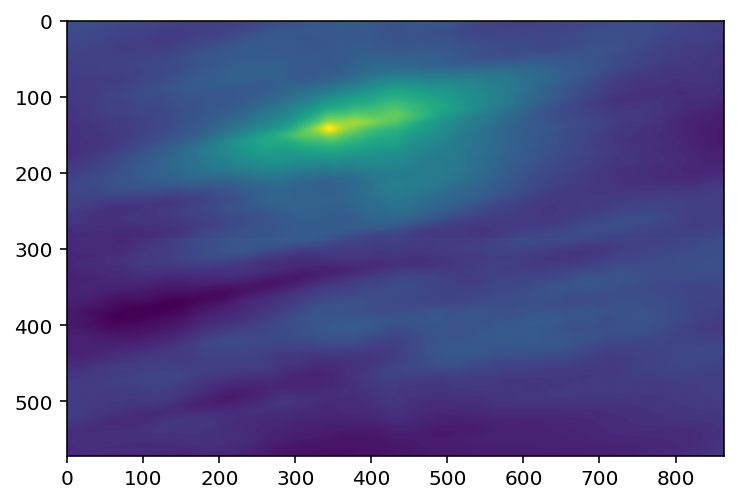

In [6]:
for i in range(len(data)):
    xx, yy = find_shift(data[0], data[1])
    break

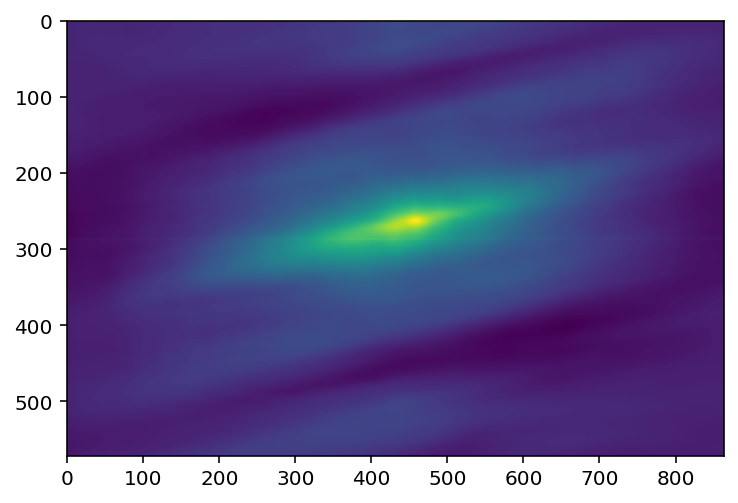

In [7]:
# find coordinates with max convolution results
x_center = []
y_center = []
for i in range(len(data)):
    xx, yy = find_shift(data[0], data[i])
    x_center = np.append(x_center, xx)
    y_center = np.append(y_center, yy)

x_shift = x_center - x_center[0]
y_shift = y_center - y_center[0]

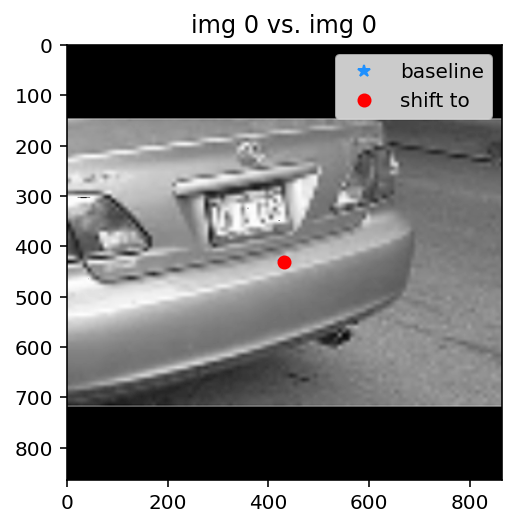

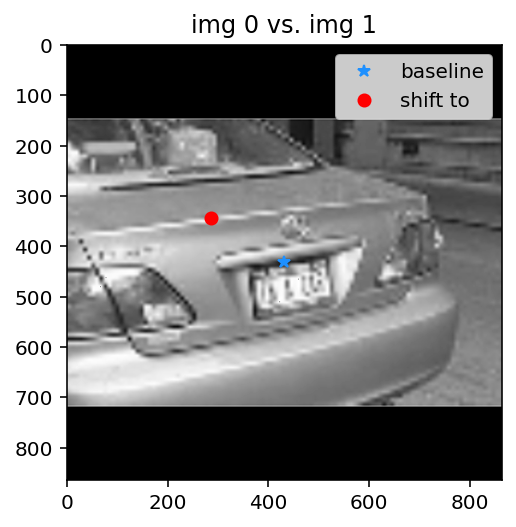

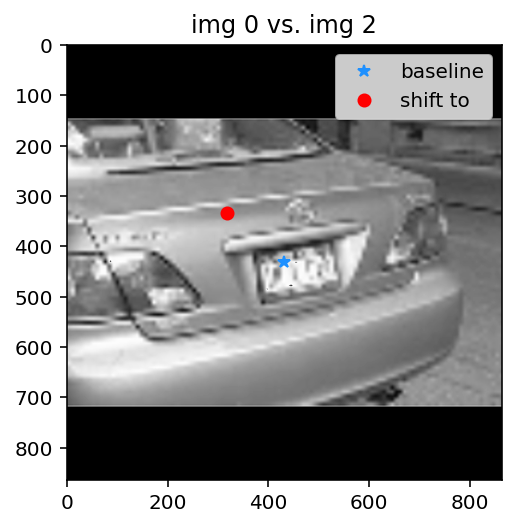

In [8]:
for i in range(3):
    plt.imshow(data[i],cmap='gray')
    plt.plot(x_center[0], y_center[0],'*', color='dodgerblue', label='baseline')
    plt.plot(x_center[i], y_center[i],'o', color='red', label='shift to')
    plt.legend()
    plt.title('img 0 vs. img ' + str(i))
    plt.show()

**Problem 2** Shift each image to register the frames to the original (expanded in size) frame. You should, in general, be shifting by subpixel offsets. You might want to look at `scipy.ndimage.interpolation.shift`

In [9]:
# shifting images!
from scipy.ndimage.interpolation import shift
data_shifted = []
for i in range(len(data)):
    data_shifted.append(shift(data[i], shift=[x_shift[i], y_shift[i]]))
data_shifted = np.array(data_shifted)

**Problem 3** Combine all the registered images to form a super-resolution image. What does the license plate read?

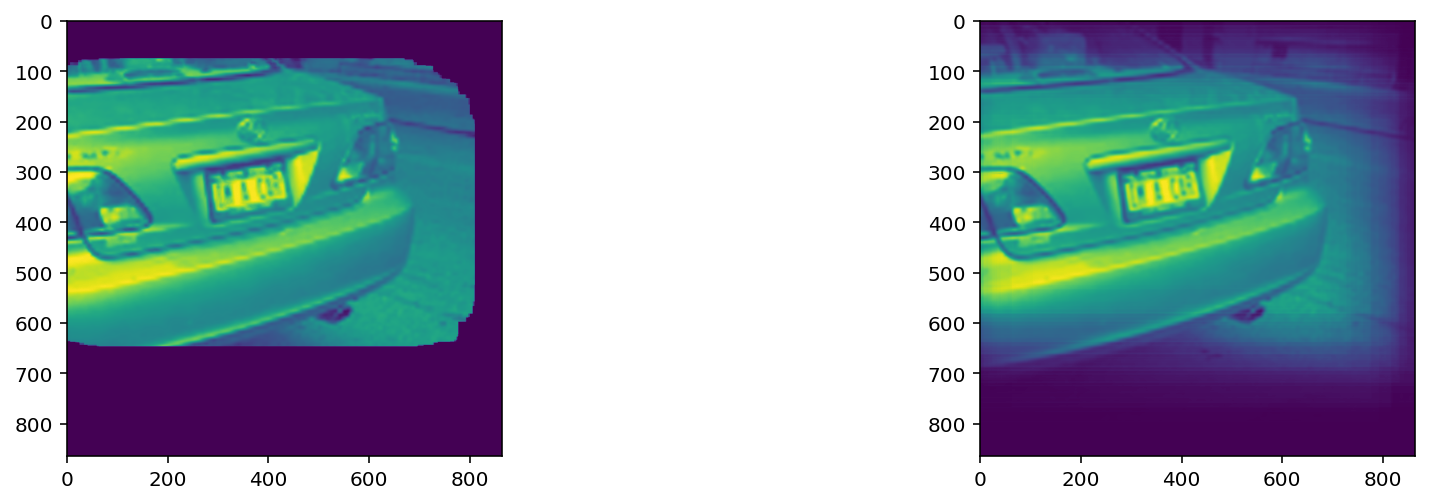

In [10]:
# combine shifted images
plt.figure(figsize=(15,4))
plt.subplot(121)
final = np.median(data_shifted, axis=0)
plt.imshow(final)
plt.subplot(122)
final = np.mean(data_shifted, axis=0)
plt.imshow(final)
plt.show()

### License plate: 'IM A CAR'!

# #2: An elementary introduction to spectral audio compression

In this problem, we'll explore the very basics of audio compression in the spectral domain using numpy and scipy. We'll do a bit of visualization with matplotlib, but since that is covered later in the course, we'll provide those functions for you.

Audio compression is a large and complex topic, and the design of a format for compressed audio such as the popular [MP3](http://en.wikipedia.org/wiki/MP3) is too complex to cover in detail here. However, we will introduce the basic tools that most such compression formats use, namely:

1. Converting the input signal to the frequency domain by taking a Fast Fourier Transform (FFT).

2. Dropping information in the frequency domain, resulting in a smaller amount of data.

3. Reconstructing back the signal in the time domain from this smaller representation of the signal.

Steps 1 and 2 above are the 'encoding' part of signal compression, and step 3 is the 'decoding' part. For this reason, the tools that perform these steps are typically referred to as signal 'codecs', short for encoders/decoders.

Note that here we say 'signal': while MP3 is an audio format, the same ideas apply to the compression of digital images with formats such as JPEG and video.  Virtually all multimedia technologies we use today, from audio players to cell phones, digital cameras and YouTubeVideo, are based on sophisticated extensions and applications of these simple ideas.

Let's first load the plotting tools and importing some tools we'll need later:

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# we'll need some path manipulations later on
import os

We define a simple utility function to listen to audio files right in the browser:

In [12]:
def Audio(fname):
    """Provide a player widget for an audio file.
    
    Parameters
    ==========
    fname : string
      Filename to be played.
      
    Warning
    =======
    
    Browsers cache audio very aggressively. If you change an
    audio file on disk and are trying to listen to the  new version, you 
    may want to 
    """
    from IPython.display import HTML, display
    
    # Find out file extension and deduce MIME type for audio format
    ext = os.path.splitext(fname)[1].replace('.', '').lower()
    mimetype = 'audio/' + ('mpeg' if ext == 'mp3' else ext)
    
    tpl = """<p>{fname}:</p>
<audio controls>
    <source src="files/{fname}" type="{mimetype}">

Your browser does not support the Audio element; you can play 
<a href="files/{fname}">this file</a> manually.
</audio>
"""
    display(HTML(tpl.format(**locals())))

We also define a convenience wrapper around `plt.specgram`, [matplotlib's spectrogram function](http://matplotlib.org/api/mlab_api.html#matplotlib.mlab.specgram), with a colorbar and control over the color limits displayed. This will make it easier to compare across different signals with the same colors for all inputs.

In [13]:
def specgram_cbar(x, title=None, clim=(0, 80) ):
    """Plot spectrogram with a colorbar and range normalization.
    
    Call matplotlib's specgram function, with a custom figure size, 
    automatic colobar, title and custom color limits to ease 
    comparison across multiple figures.
    
    Parameters
    ==========
    x : array
      One-dimensional array whose spectrogram should be plotted.
      
    title : string
      Optional title for the figure.
      
    clim : 2-tuple
      Range for the color limits plotted in the spectrogram.
    """
    f = plt.figure(figsize=(10,3))
    plt.specgram(x, Fs=2)
    plt.colorbar()
    plt.clim(*clim)
    if title is not None:
        plt.title(title)
    plt.show()

**Problem 1**: Use the `Audio` function above to listen to the signal we will be experimenting with, a simple voice recording stored in the file `Homeworks/hw1/data/voice.wav`.

Note: if your browser doesn't support audio, you may try a different browser.   We've tested current versions of Chrome and Firefox, and it works OK with both.

In [14]:
# your code here
Audio('data/voice.wav')

**Problem 2**: Write a function to compress a 1-d signal by dropping a fraction of its spectrum. 

You can drop the smallest components by setting their values to zero.

*Hints*: 

- look at the `np.fft` module, keeping in mind that your input signal is real.
- look at the `argsort` method of numpy arrays.

In [15]:
def compress_signal(x, fraction):
    """Compress an input signal by dropping a fraction of its spectrum.
    
    Parameters
    ==========
    x : array
      1-d real array to be compressed
      
    fraction : float
      A number in the [0,1] range indicating which fraction of the spectrum
      of x should be zeroed out (1 means zero out the entire signal).
      
    Returns
    =======
    x_approx : array
      1-d real array reconstructed after having compressed the input.
    """
    # your code here
    fraction = int(fraction * len(x))
    x_freq = np.fft.fft(x)
    x_freq_approx = x_freq.copy()
    order = np.argsort(np.abs(x_freq)) # small to large. # NOTE: np.abs? 
    for i in range(fraction):
        x_freq_approx[order[i]] = 0
    # print('x_freq:', x_freq)
    # print('x_freq_approx:', x_freq_approx)

    x_approx = np.fft.ifft(x_freq_approx)
    return x_approx

As a quick visual check (not that this is *not* a formal test of correctness), experiment with a simple random signal by changing the compression ratio and plotting both the signal and the compressed version:

In [16]:
x = np.random.rand(128)

/Users/yang/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


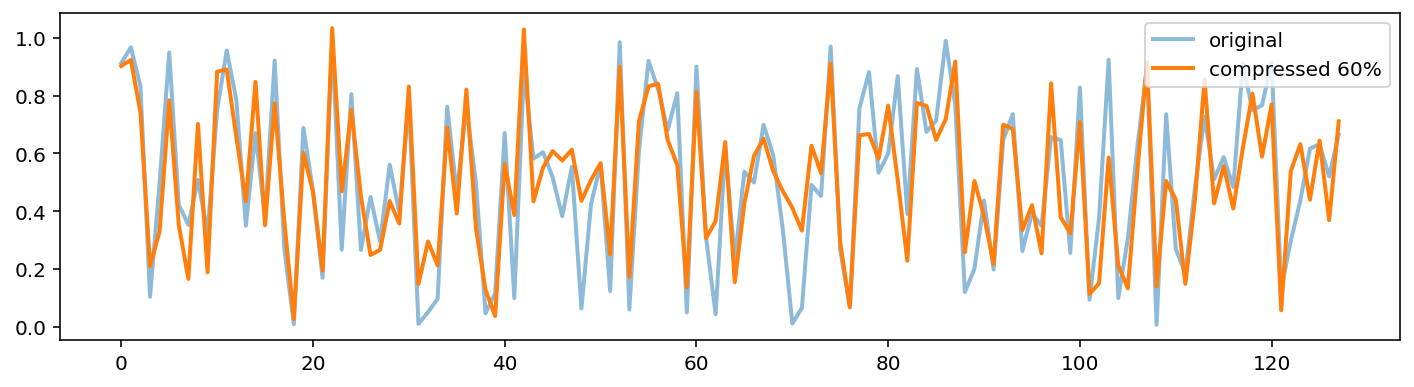

In [17]:
fraction = 0.6  # play changing this in the 0-1 range

xa = compress_signal(x, fraction)

plt.figure(figsize=(12,3))
plt.plot(x, alpha=0.5, lw=2, label='original')
plt.plot(xa, lw=2, label='compressed {0:.0%}'.format(fraction))
plt.legend();

**Problem 3**: Write a function that will compress an audio file by a dropping a fraction of its spectrum, writing the output to a new file.

If the input file is named `a.wav` and the compression fraction is 0.9, the output file should be named `a_comp_0.9.wav`.

*Hints:* 

- look at the `scipy.io` module for routines dealing with files in `wav` format.

- you may need to use the `astype` method of numpy arrays to get the correct data type for `wav` files.

In [18]:
import scipy.io
from scipy.io import wavfile
def compress_wav(fname, fraction):
    """Compress an audio signal stored in an input wav file.
    
    The compressed signal is returned as a numpy array and automatically written 
    to disk to a new wav file.
    
    Parameters
    ==========
    fname : string
      Name of the input wav file
      
    fraction : float
      Fraction of input data to keep.
      
    Returns
    =======
    rate : int
      Bit rate of the input signal.

    x : array
      Raw data of the original input signal.
      
    x_approx : array
      Raw data of the compressed signal.
      
    new_fname : string
      Auto-generated filename of the compressed signal.
    """
    
    rate, wav_data = wavfile.read(fname)
    # print('wav_data:', wav_data)
    x = np.array(wav_data)
    # print('x:', x)
    x_approx = compress_signal(x, fraction).astype('int16') # NOTE: what dtype?
    # print('x_approx:', x_approx)
    new_fname = fname.split('.')[0] + '_comp_' + str(fraction) + '.wav'
    wavfile.write(new_fname, rate, x_approx)

    # plt.figure(figsize=(20,3))
    # plt.plot(wav_data,lw=1,label='orig')
    # plt.plot(x_approx,'--',lw=1,label='approx')
    # plt.legend()

    return rate, x, x_approx, new_fname


In [19]:
# testing
compress_wav('data/voice.wav', 0.751);

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part


**Problem 4**: Study the effect of compressing the input file at different ratios: 0.1, 0.5, 0.75, 0.9, 0.95, 0.99.

Using the `OrderedDict` class from the [Python collections module](https://docs.python.org/3/library/collections.html#collections.OrderedDict), store the uncompressed signal as well as the compressed array and filename for each compression ratio.

You will create an `OrderedDict` called `voices`, with:

- keys: compression ratios
- values: pairs of (x, filename) where x is the compressed audio and filename is the name of the compressed file.

In [20]:
from collections import OrderedDict

voices = OrderedDict()
for ratio in [0.0, 0.1, 0.5, 0.75, 0.9, 0.95, 0.99]:
    rate, x, x_approx, new_fname = compress_wav('data/voice.wav', ratio)
    voices[ratio] = (x_approx, new_fname)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part


**Problem 5**: Loop over the `voices` dict, and for each one generate an audio player as well as a spectrogram.  Observe how the spectrogram changes, and listen to each file.  At what ratio do you stop understanding the recording?

commpression ratio: 0.0


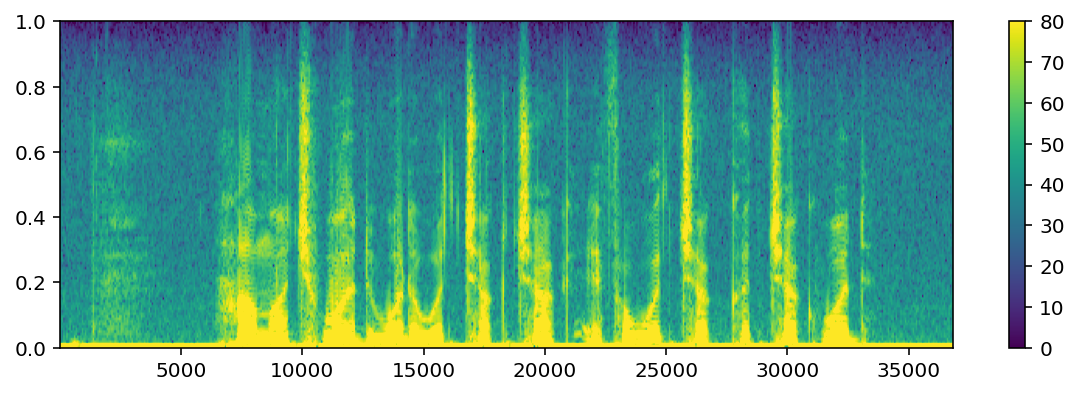

commpression ratio: 0.1


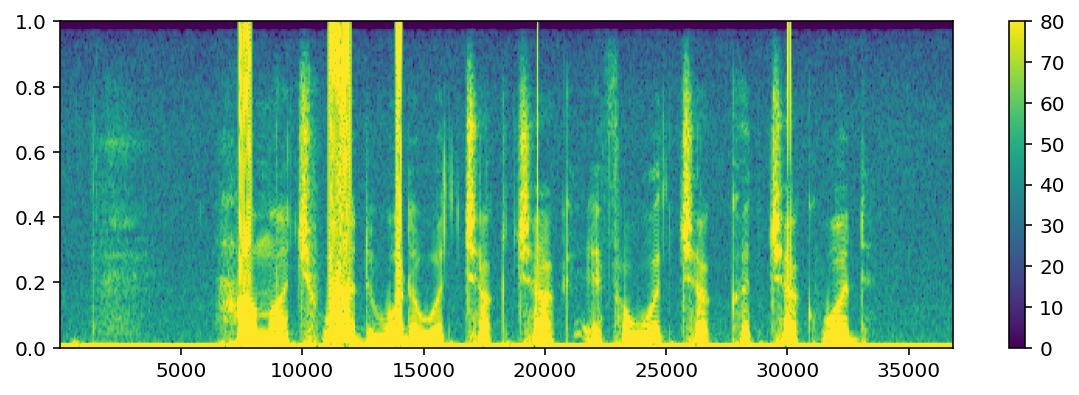

commpression ratio: 0.5


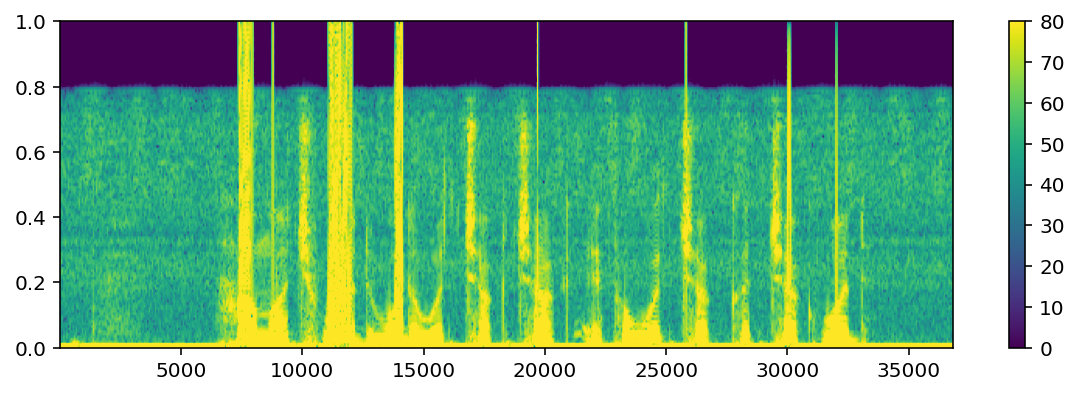

commpression ratio: 0.75


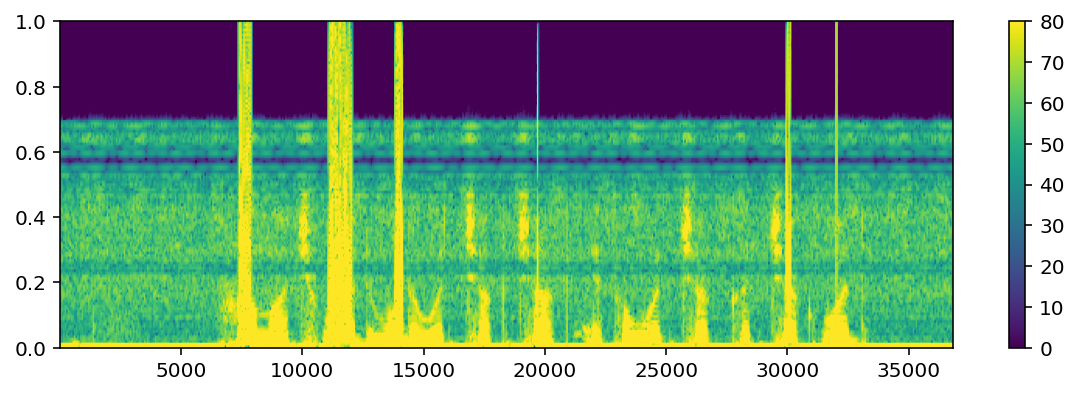

commpression ratio: 0.9


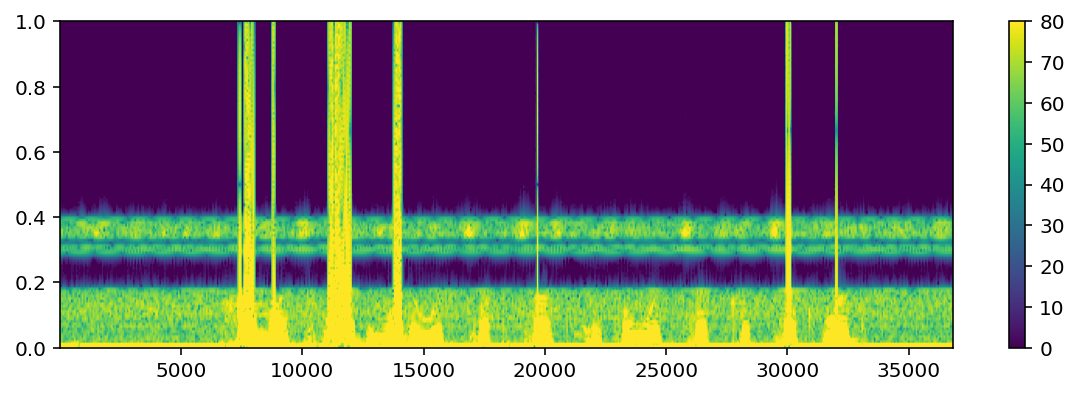

commpression ratio: 0.95


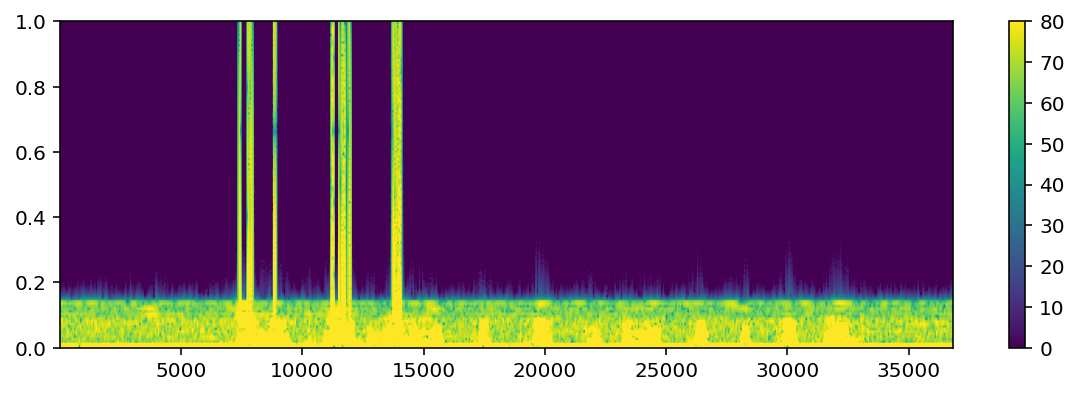

commpression ratio: 0.99


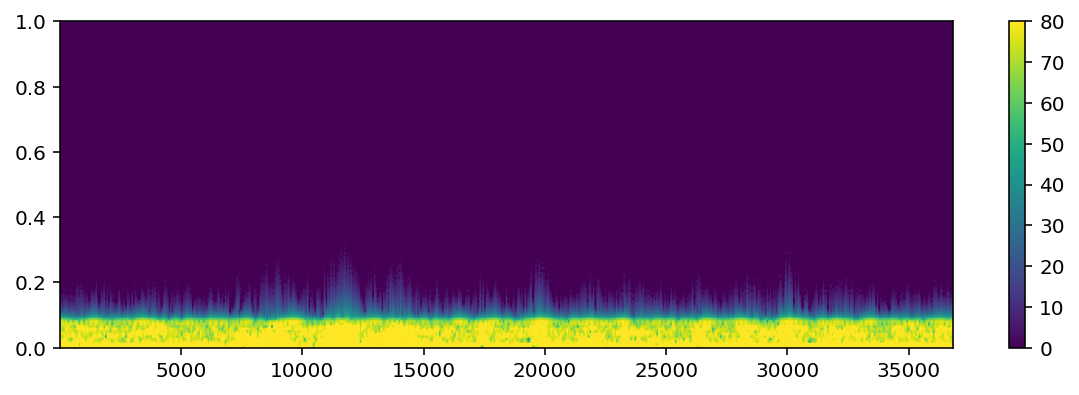

In [21]:
for ratio, (x_approx, new_fname) in voices.items():
    print('commpression ratio:', ratio)
    Audio(new_fname)
    specgram_cbar(x_approx)

### The sentence is barely dicernable at 0.95 compression. It's impossible to understand at 0.99 compression ratio.

# #3: Armchair Astronomer

Often times, people act as good sensors of the physical universe. We can use Google Trends data to help us determine some fundamental parameters of the Solar System.

**Problem 1**: Using just the CSV file we created in the pandas lecture (`merged_data.csv`) and some frequency analysis tools in `scipy` to determine:

   - the number of days in a year
   - the period of the moon's orbit around the Earth
   
Hint: `from scipy.signal.spectral import lombscargle` (you'll want to normalize your signal so it has a mean of zero.)

In [22]:
import pandas as pd
from scipy.signal.spectral import lombscargle
df = pd.read_csv('data/merged_data.csv')
df.head()

Week  tennis  ice cream  full moon
0  2017-01-29      17         11         10
1  2017-02-05      13         11         40
2  2017-02-12      15         12         11
3  2017-02-19      16         13          9
4  2017-02-26      16         12         11

In [23]:
df.reset_index(inplace=True)
df.rename(columns={'index':'week'}, inplace=True)

In [24]:
df.head()

week        Week  tennis  ice cream  full moon
0     0  2017-01-29      17         11         10
1     1  2017-02-05      13         11         40
2     2  2017-02-12      15         12         11
3     3  2017-02-19      16         13          9
4     4  2017-02-26      16         12         11

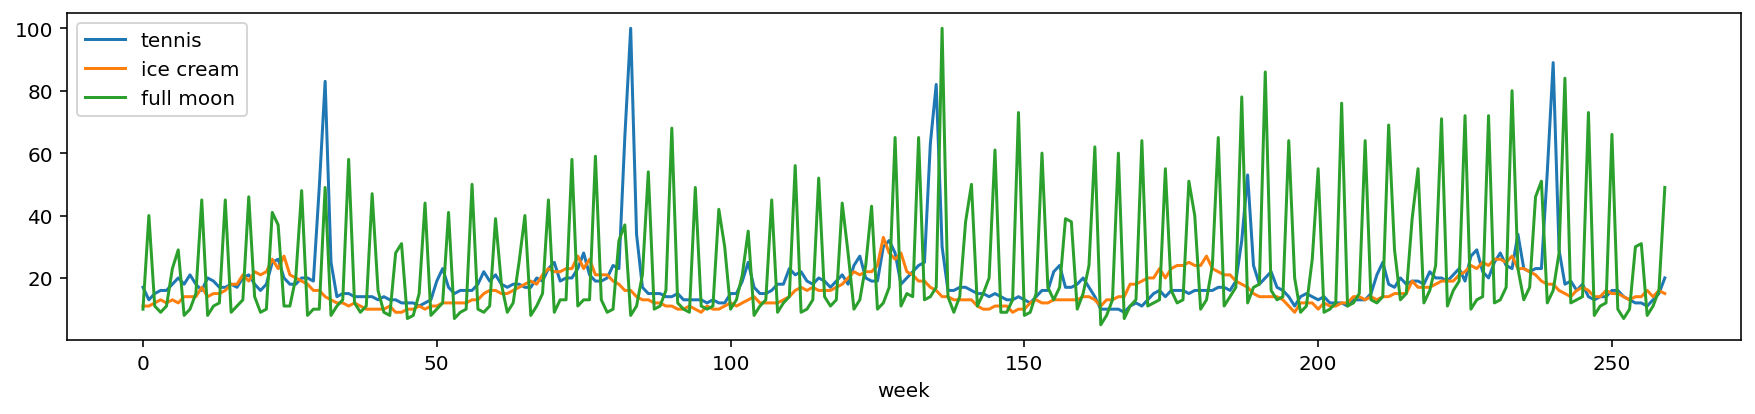

In [25]:
plt.figure(figsize=(15,3))
plt.plot(df['week'], df['tennis'],label='tennis')
plt.plot(df['week'], df['ice cream'],label='ice cream')
plt.plot(df['week'], df['full moon'],label='full moon')
plt.legend()
plt.xlabel('week')
plt.show()

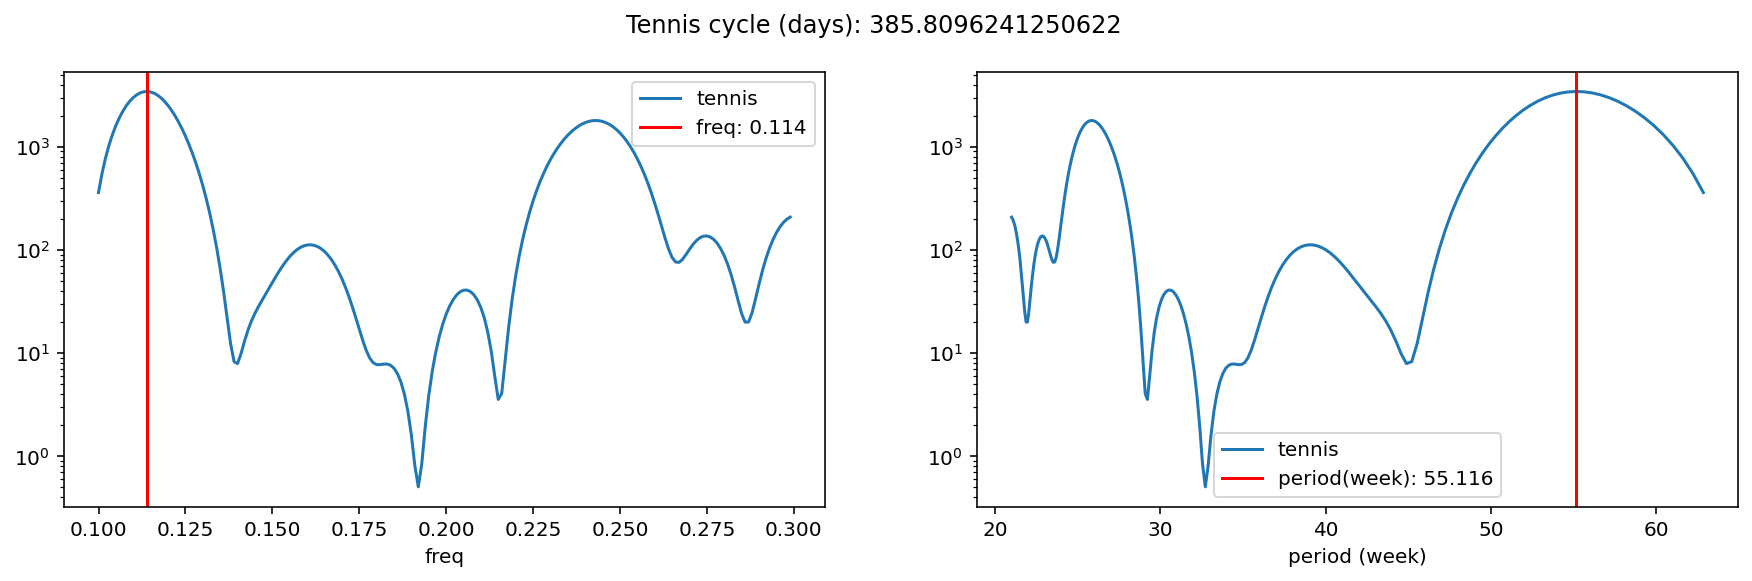

In [26]:
freqs_tennis = np.arange(0.1, 0.3, 0.001)
y_tennis = lombscargle(df['week'], df['tennis'], freqs=freqs_tennis)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(freqs_tennis, y_tennis, label='tennis')
w_tennis = freqs_tennis[np.argmax(y_tennis)]
plt.axvline(w_tennis, color='red', label='freq: '+str(np.round(w_tennis,3)))
plt.xlabel('freq')
plt.legend()
plt.yscale('log')

plt.subplot(122)
period_tennis = 2*np.pi/freqs_tennis
plt.plot(period_tennis, y_tennis, label='tennis')
T_tennis = period_tennis[np.argmax(y_tennis)]
plt.axvline(T_tennis, color='red', label='period(week): '+str(np.round(T_tennis,3)))
plt.xlabel('period (week)')
plt.legend()
plt.yscale('log')
plt.suptitle('Tennis cycle (days): '+str(T_tennis*7))
plt.show()


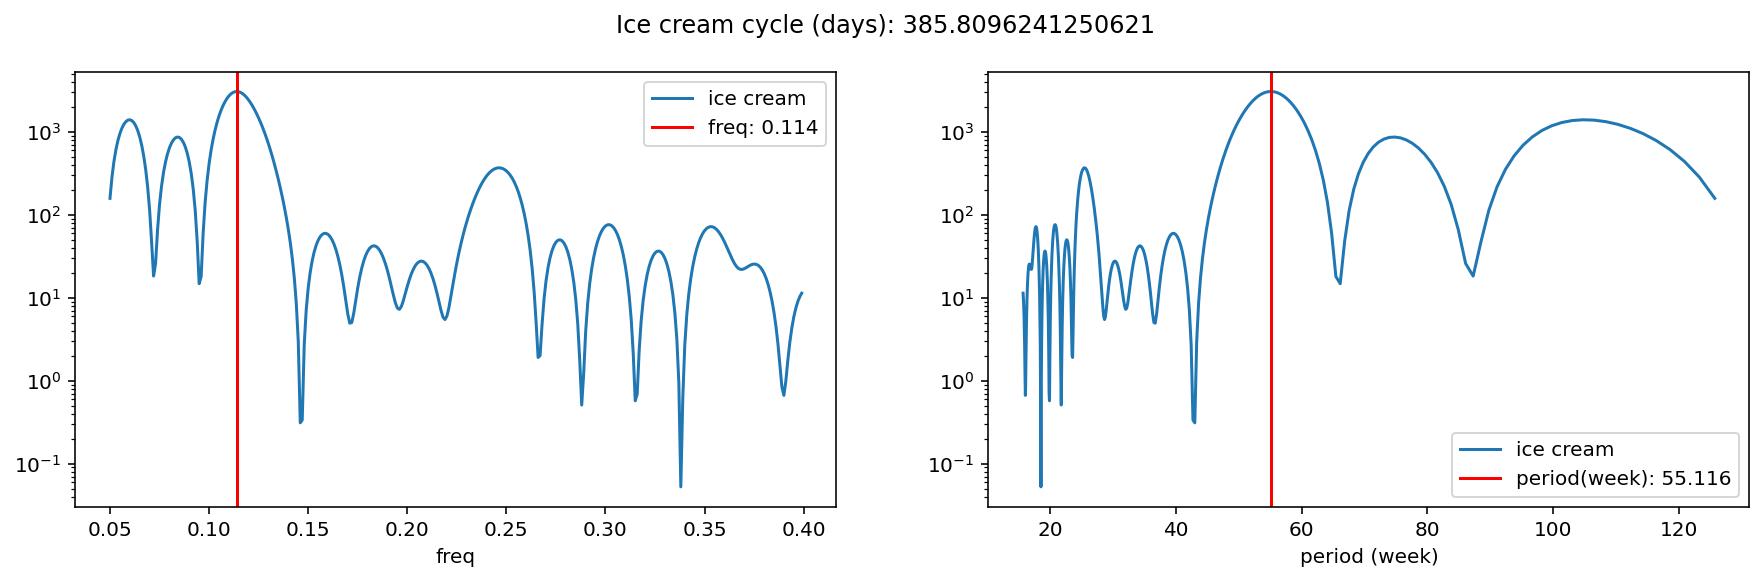

In [27]:
freqs_ice = np.arange(0.05, 0.4, 0.001)
y_ice = lombscargle(df['week'], df['ice cream'], freqs=freqs_ice)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(freqs_ice, y_ice, label='ice cream')
w_ice = freqs_ice[np.argmax(y_ice)]
plt.axvline(w_ice, color='red', label='freq: '+str(np.round(w_ice,3)))
plt.xlabel('freq')
plt.legend()
plt.yscale('log')

plt.subplot(122)
period_ice = 2*np.pi/freqs_ice
plt.plot(period_ice, y_ice, label='ice cream')
T_ice = period_ice[np.argmax(y_ice)]
plt.axvline(T_ice, color='red', label='period(week): '+str(np.round(T_ice,3)))
plt.xlabel('period (week)')
plt.legend()
plt.yscale('log')
plt.suptitle('Ice cream cycle (days): '+str(T_ice*7))
plt.show()


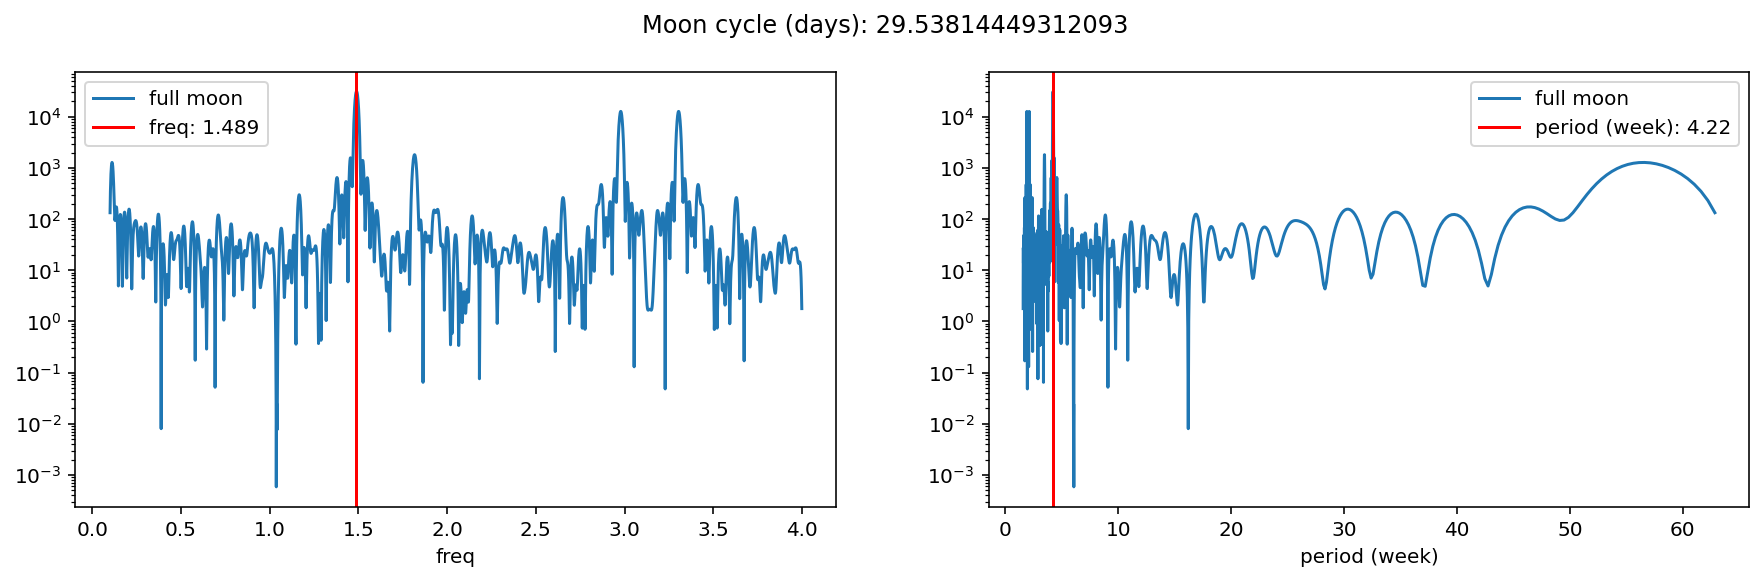

In [28]:
freqs_moon = np.arange(0.1, 4, 0.001)
y_moon = lombscargle(df['week'], df['full moon'], freqs=freqs_moon)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(freqs_moon, y_moon, label='full moon')
w_moon = freqs_moon[np.argmax(y_moon)]
plt.axvline(w_moon, color='red', label='freq: '+str(np.round(w_moon,3)))
plt.xlabel('freq')
plt.legend()
plt.yscale('log')

plt.subplot(122)
period_moon = 2*np.pi/freqs_moon
plt.plot(period_moon, y_moon, label='full moon')
T_moon = period_moon[np.argmax(y_moon)]
plt.axvline(T_moon, color='red', label='period (week): '+str(np.round(T_moon,3)))
plt.xlabel('period (week)')
plt.legend()
plt.yscale('log')
plt.suptitle('Moon cycle (days): '+str(T_moon*7))
plt.show()


### Number of days in a year: 385 days (something weird is going on..)
### Period of moon's orbit: 29.5 days

### backup...

In [29]:
# t = np.arange(0,100)
# w = 2*np.pi * 0.0245
# T = 2*np.pi/w
# print(w, T)
# y = np.sin(w * t)
# plt.plot(t,y)
# plt.axvline(T)

In [30]:
# freqs=np.linspace(0.001, 1, 100)
# f = lombscargle(t, y, freqs=freqs)
# plt.plot(freqs, f)
# plt.axvline(w)